<a href="https://colab.research.google.com/github/LEEINSEO-0118/Brand_Detective/blob/main/Similarity_Measure/Similarity_Measure_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [113]:
import os
import fnmatch
import zipfile
from tqdm import tqdm

import cv2

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = '/content/drive/MyDrive/ai부트캠프/Final_Project/Data'

#SEED


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2024) # Seed 고정

# Upscaling

In [6]:
# Define model
sr2 = cv2.dnn_superres.DnnSuperResImpl_create()
sr3 = cv2.dnn_superres.DnnSuperResImpl_create()
sr2.readModel('/content/drive/MyDrive/ai부트캠프/Final_Project/Similarity_Measure/EDSR_x2.pb')
sr3.readModel('/content/drive/MyDrive/ai부트캠프/Final_Project/Similarity_Measure/EDSR_x3.pb')
sr2.setModel('edsr', 2)
sr3.setModel('edsr', 3)

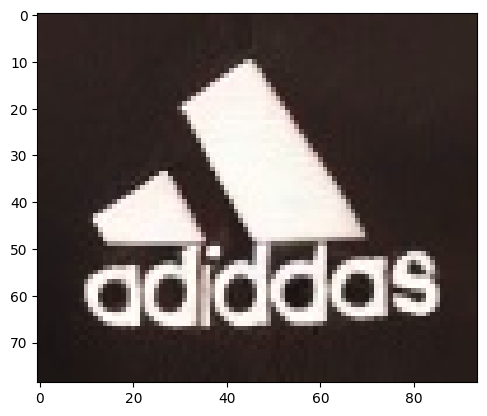

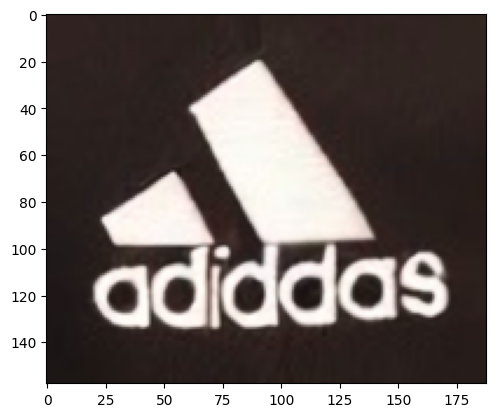

In [7]:
path = f'{data}/image_for_similarity/adidas/adidas_sports_fake_3_1.jpg'

img = cv2.imread(path)
upscaled = sr2.upsample(img)

plt.subplots(1)
plt.imshow(img)
plt.subplots(1)
plt.imshow(upscaled)
plt.show()

# View Images


adidas_sports_logo.png


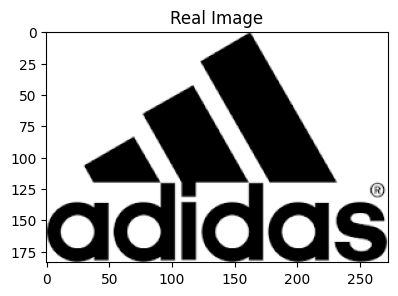

In [8]:
fig = plt.figure(figsize=(15, 15))
rows = 3
cols = 3
i = 1

for file_name in os.listdir(f'{data}/LOGO'):
    print(file_name)
    image = cv2.imread(f'{data}/LOGO/{file_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image)
    i += 1
plt.title('Real Image')
plt.show()

crop_image_2_1.jpg
crop_image_1_1.jpg
crop_image_3_1.jpg
crop_image_4_1.jpg
crop_image_4_2.jpg


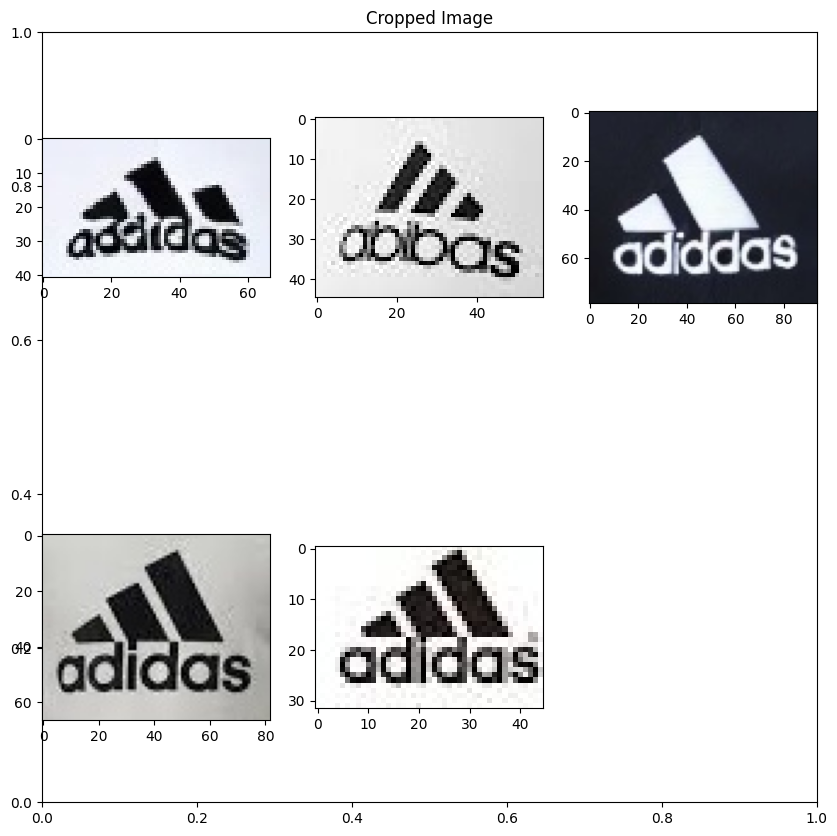

In [23]:
fig = plt.figure(figsize=(10, 10))
rows = 2
cols = 3
i = 1
plt.title('Cropped Image')

for file_name in os.listdir(f'{data}/cropped'):
    print(file_name)
    image = cv2.imread(f'{data}/cropped/{file_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image)
    i += 1
plt.show()

### Delete Cropped Data

In [57]:
for file_path in os.listdir(f'/content/drive/MyDrive/ai부트캠프/Final_Project/Data/cropped'):
    os.remove(f'/content/drive/MyDrive/ai부트캠프/Final_Project/Data/cropped/{file_path}')

# Extraction matching

### ORB

In [44]:
img.shape[1]

163

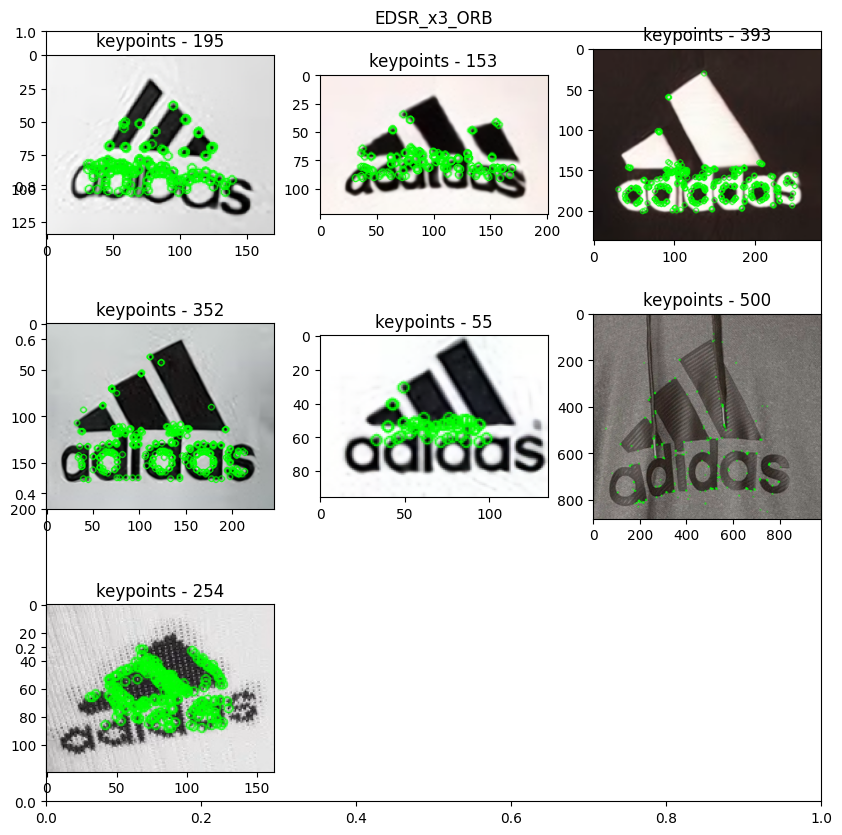

In [12]:
fig = plt.figure(figsize=(10, 10))
rows = 3
cols = 3
i = 1
plt.title('EDSR_x3_ORB')

for file_name in os.listdir(f'{data}/cropped'):
    path = f'{data}/cropped/{file_name}'
    img = cv2.imread(path)

    # upsampling
    if img.shape[0] < 100 or img.shape[1] < 100:
        img = sr.upsample(img)

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # find the keypoints with ORB and compute the descriptors
    kp, des = orb.detectAndCompute(img,None)

    # draw only keypoints location,not size and orientation
    img = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)

    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    plt.title(f'keypoints - {len(kp)}')
    i += 1
plt.show()

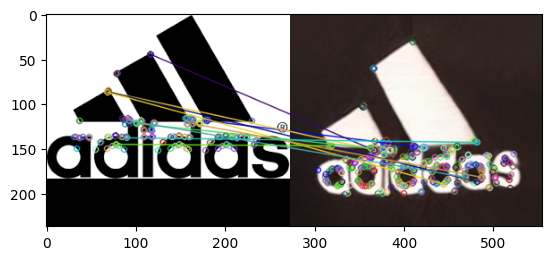

In [43]:
path1 = f'{data}/LOGO/adidas_sports_logo.png'
# path2 = f'{data}/LOGO/adidas_sports_logo.png'
path2 = f'{data}/cropped/crop_image_3_1.jpg'
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
res = None

# upsampling cropped image
if img2.shape[0] < 100 or img2.shape[1] < 100:
    img2 = sr.upsample(img2)

# Initiate ORB detector
orb = cv2.ORB_create()

# compute the descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Define Matcher
# ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# 가장 유사한 쌍 부터 n개의 쌍 연결
n = 10
res = cv2.drawMatches(img1,kp1,img2,kp2,matches[:n],res,flags=0)
plt.imshow(res)
plt.show()

In [44]:
print(f'{(len(matches)/max(len(kp1), len(kp2)))*100}%')

15.521628498727736%


In [32]:
print(len(kp1), len(des1))
print(len(kp2), len(des2))

162 162
500 500


In [33]:
print(len(matches))

55


In [74]:
dists = [match_.distance for match_ in matches]
print(dists[0:10])
print(f'Top 10 avg - {round(sum(dists[0:10])/10, 2)}')
print(f'Total avg - {round(sum(dists)/len(dists),2)}')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Top 10 avg - 0.0
Total avg - 0.0


### AKAZE

error: OpenCV(4.8.0) /io/opencv/modules/dnn/src/layers/convolution_layer.cpp:416: error: (-2:Unspecified error) Number of input channels should be multiple of 3 but got 1 in function 'getMemoryShapes'


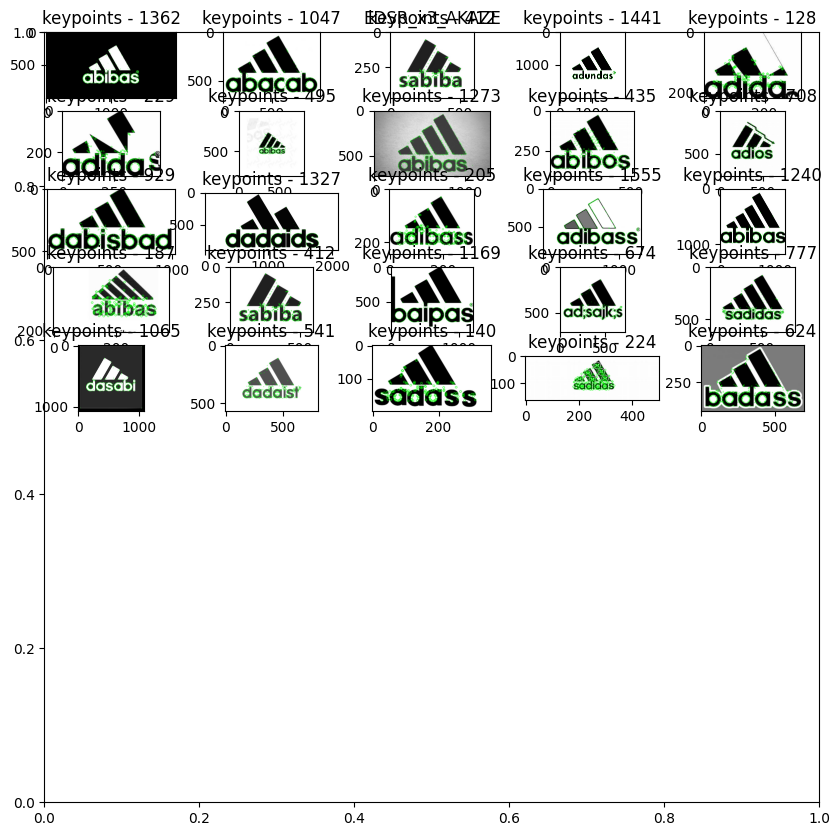

In [84]:
fig = plt.figure(figsize=(10, 10))
rows = 10
cols = 5
i = 1
plt.title('EDSR_x3_AKAZE')

for file_name in os.listdir(f'{data}/image_for_similarity/adidas'):
    path = f'{data}/image_for_similarity/adidas/{file_name}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # upsampling
    if img.shape[0] < 100 or img.shape[1] < 100:
        img = sr2.upsample(img)

    # Initiate ORB detector
    akaze = cv2.AKAZE_create()

    # compute the descriptors with ORB
    kp, des = akaze.detectAndCompute(img,None)

    # draw only keypoints location,not size and orientation
    img = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)

    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    plt.title(f'keypoints - {len(kp)}')
    i += 1
plt.show()

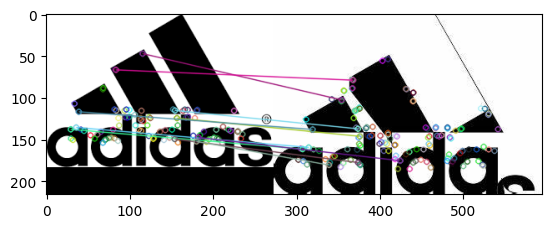

In [47]:
path1 = f'{data}/LOGO/adidas_sports_logo.png'
# path2 = f'{data}/LOGO/adidas_sports_logo.png'
# path2 = f'{data}/image_for_similarity/adidas/fake_adidas_36.jpg'
path2 = '/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_18.jpg'
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
res = None

# upsampling cropped image
if img2.shape[0] < 100 or img2.shape[1] < 100:
    img2 = sr2.upsample(img2)

# Initiate ORB detector
akaze = cv2.AKAZE_create()

# compute the descriptors with ORB
kp1, des1 = akaze.detectAndCompute(img1,None)
kp2, des2 = akaze.detectAndCompute(img2,None)

# Define Matcher
# ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# 가장 유사한 쌍 부터 n개의 쌍 연결
n = 10
res = cv2.drawMatches(img1,kp1,img2,kp2,matches[:n],res,flags=0)
plt.imshow(res)
plt.show()

In [48]:
print(f'{(len(matches)/max(len(kp1), len(kp2)))*100}%')

36.71875%


In [49]:
dists = [match_.distance for match_ in matches]
print(dists)
print(f'Top 10 avg - {round(sum(dists[0:10])/10, 2)}')
print(f'Total avg - {round(sum(dists)/len(dists),2)}')

[32.0, 33.0, 38.0, 45.0, 46.0, 48.0, 49.0, 52.0, 53.0, 56.0, 58.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0, 63.0, 64.0, 65.0, 65.0, 66.0, 67.0, 68.0, 68.0, 68.0, 70.0, 70.0, 72.0, 73.0, 73.0, 74.0, 75.0, 77.0, 78.0, 79.0, 86.0, 87.0, 91.0, 95.0, 99.0, 107.0, 116.0, 117.0, 119.0, 148.0, 163.0]
Top 10 avg - 45.2
Total avg - 73.09


#Matchs to CSV

In [7]:
cols = ['name', 'image_type', 'path', 'kp_counts_1', 'kp_counts_2', 'match_counts', 'dists_median', 'top_10_avg', 'total_avg']
dicts = {col:[]for col in cols}
dicts

{'name': [],
 'image_type': [],
 'path': [],
 'kp_counts_1': [],
 'kp_counts_2': [],
 'match_counts': [],
 'dists_median': [],
 'top_10_avg': [],
 'total_avg': []}

In [107]:
cols = ['name', 'image_type', 'path', 'kp_counts_1', 'kp_counts_2', 'match_counts', 'dists_median', 'top_10_avg', 'total_avg']
dicts = {col:[] for col in cols}

for file_name in tqdm(os.listdir(f'{data}/image_for_similarity/adidas')):
    path1 = f'{data}/LOGO/adidas_sports_logo.png'
    path2 = f'{data}/image_for_similarity/adidas/{file_name}'
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    res = None

    # upsampling cropped image
    while img2.shape[1] < 200:
        img2 = sr2.upsample(img2)
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # to gray scale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initiate ORB detector
    akaze = cv2.AKAZE_create()

    # compute the descriptors with ORB
    kp1, des1 = akaze.detectAndCompute(img1,None)
    kp2, des2 = akaze.detectAndCompute(img2,None)

    # Define Matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    dists = [match_.distance for match_ in matches]
    # 'fake' 또는 'real' 추출
    parts = file_name.split('_')
    if 'fake' in parts:
        label = 'fake'
    elif 'real' in parts:
        label = 'real'
    else:
        label = None

    lists = [file_name, label, path2, len(kp1), len(kp2), len(matches), np.median(dists), round(sum(dists[0:10])/10, 2), round(sum(dists)/len(dists),2)]
    for i, col in enumerate(cols):
        dicts[col].append(lists[i])

matches_df = pd.DataFrame(dicts, columns=cols)

100%|██████████| 45/45 [01:35<00:00,  2.12s/it]


In [108]:
fake = matches_df[matches_df.image_type == 'fake']
real = matches_df[matches_df.image_type == 'real']

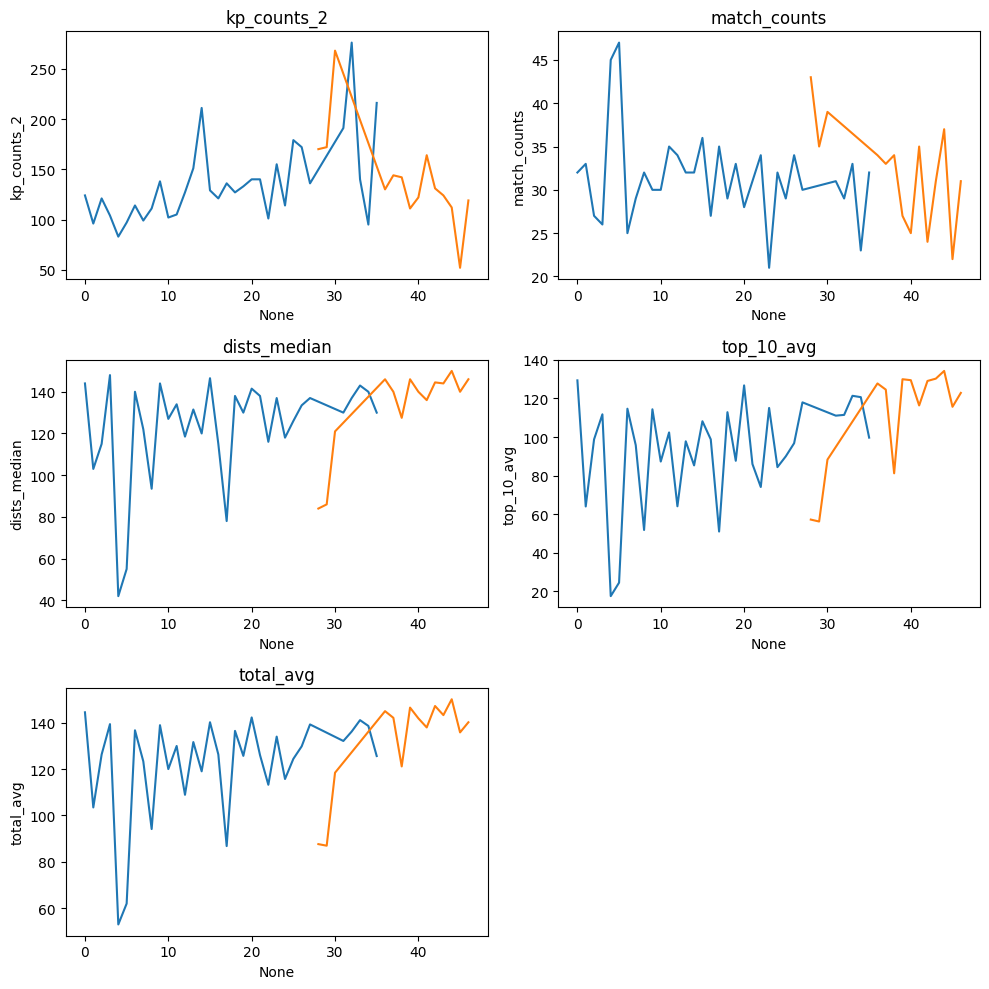

In [12]:
cols = ['kp_counts_2', 'match_counts', 'dists_median', 'top_10_avg', 'total_avg']
fig = plt.figure(figsize=(10, 10))
for i, col in enumerate(cols):
    plt.subplot(3,2,i+1)
    plt.title(col)
    sns.lineplot(fake, x=fake.index, y=col)
    sns.lineplot(real, x=real.index, y=col)
    plt.tight_layout()

<ipython-input-82-273f1dedf830>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)


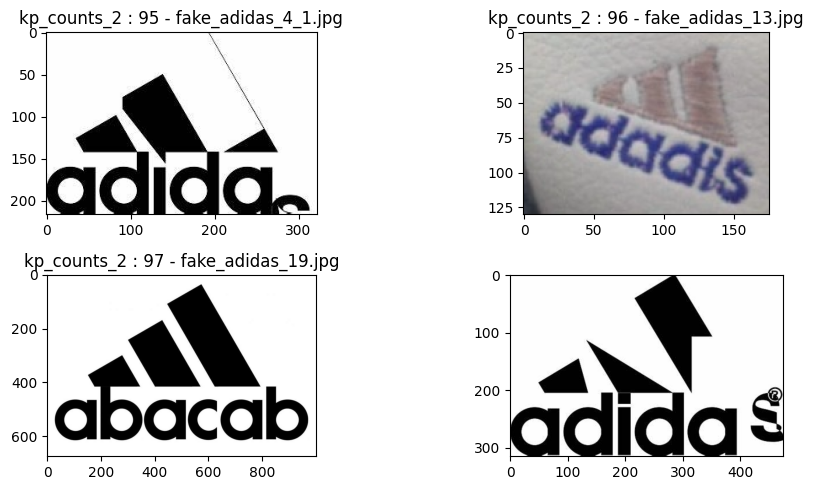

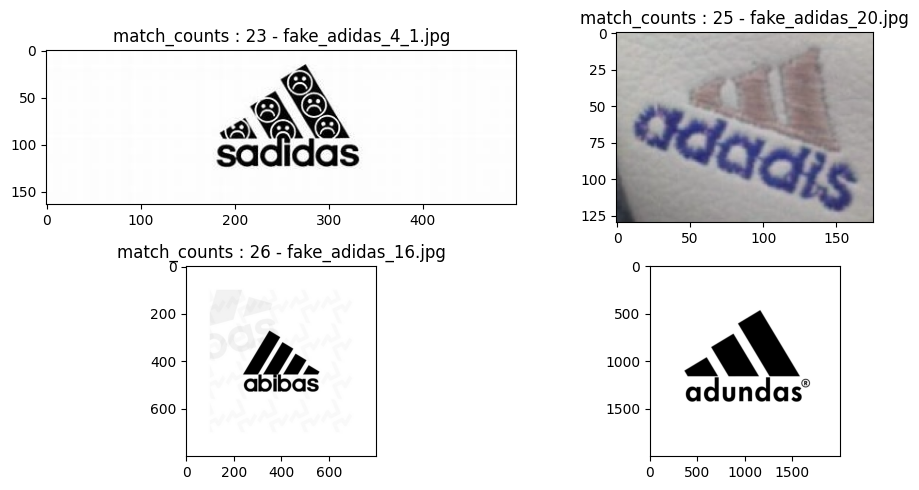

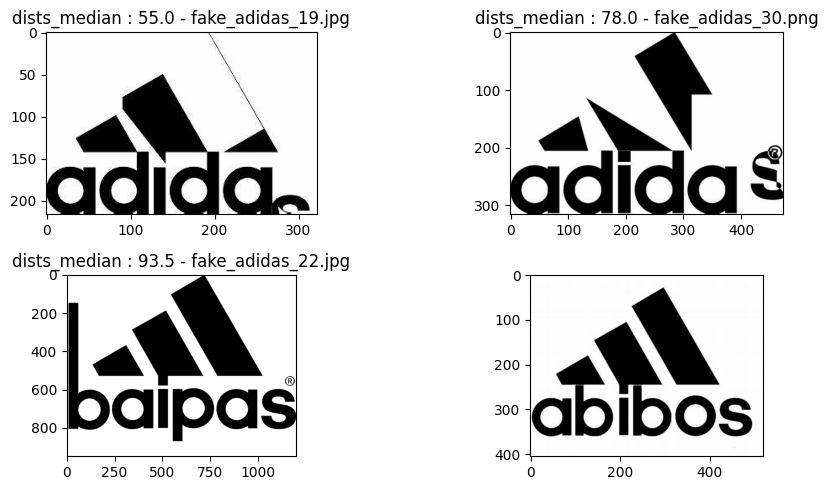

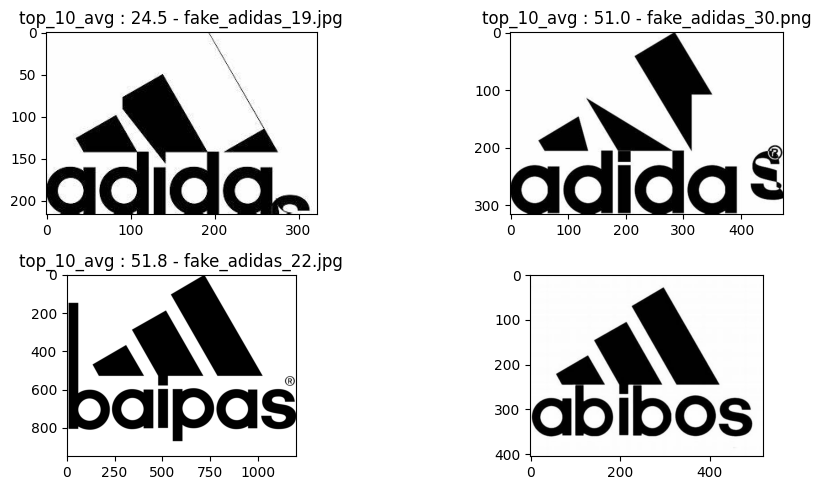

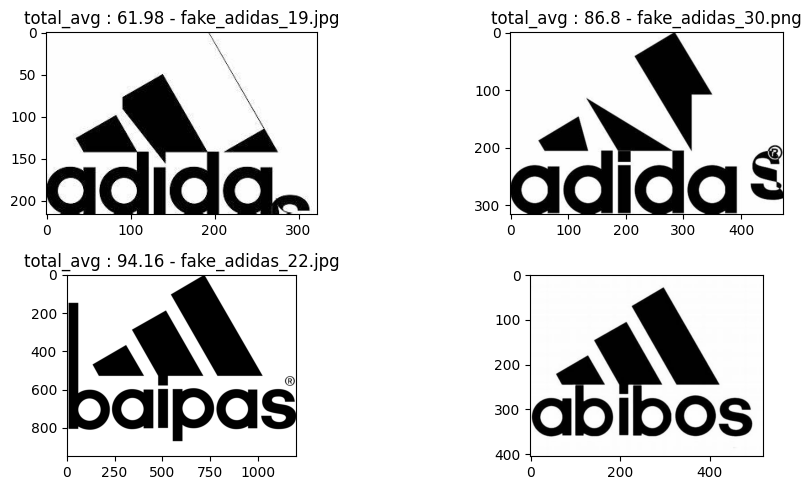

In [82]:
cols = ['kp_counts_2', 'match_counts', 'dists_median', 'top_10_avg', 'total_avg']

for col in cols:
    paths = list(fake.sort_values(by=col, ascending=True)[:4].path)
    stats = fake.sort_values(by=col, ascending=True)[:4][col].values

    fig = plt.figure(figsize=(10, 5))
    for i, path in enumerate(paths):
        image = cv2.imread(path)
        name = path.split('/')[-1]
        plt.title(f'{col} : {stats[i]} - {name}')
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
    plt.tight_layout()

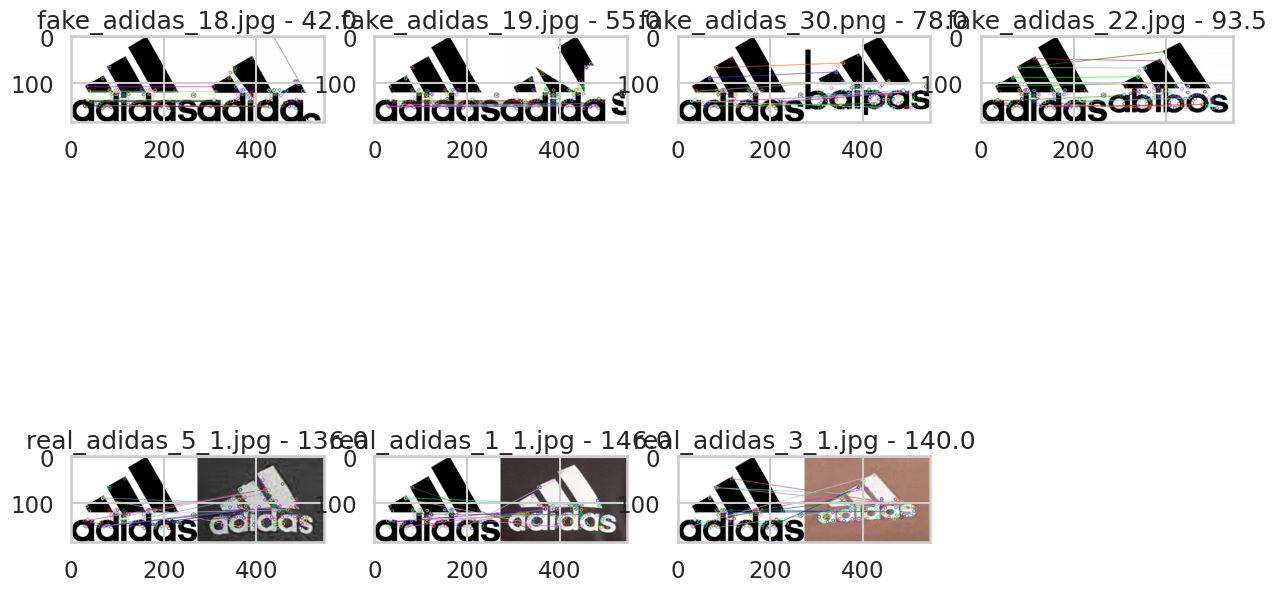

In [123]:
paths = []
paths.extend(list(fake.sort_values(by='total_avg', ascending=True)[:4].path))
paths.extend(list(real.sort_values(by='total_avg', ascending=True)[5:8].path))

fig = plt.figure(figsize=(15, 10))
rows = 2
cols = 4
i = 1

for path2 in paths:
    path1 = f'{data}/LOGO/adidas_sports_logo.png'
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    res = None

    # upsampling cropped image
    # print(f'before{img2.shape}')
    while img2.shape[1] < 200:
        img2 = sr2.upsample(img2)
    # print(f'after{img2.shape}')
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    # print(f'resize{img2.shape}')

    # Initiate AKAZE detector
    akaze = cv2.AKAZE_create()

    # compute the descriptors with ORB
    kp1, des1 = akaze.detectAndCompute(img1,None)
    kp2, des2 = akaze.detectAndCompute(img2,None)

    # Define Matcher
    # ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    dists = [match_.distance for match_ in matches]

    # 가장 유사한 쌍 부터 n개의 쌍 연결
    n = 10
    res = cv2.drawMatches(img1,kp1,img2,kp2,matches[:n],res,flags=0)
    ax = fig.add_subplot(rows, cols, i)
    name = path2.split('/')[-1]
    ax.set_title(f'{name} - {np.median(dists)}')
    # ax.set_title(f'{name} - {len(kp1), len(kp2)}')
    ax.imshow(res)
    i += 1
plt.show()

# Compare Image

### Align Image function

In [11]:
# def align_images(image1, image2, matches, keypoints1, keypoints2):
#     points1 = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
#     points2 = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

#     M, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

#     aligned_img = cv2.warpPerspective(image2, M, (image1.shape[1], image1.shape[0]))

#     return aligned_img

In [61]:
def display_aligned_images(image1, image2, aligned_img):
    # 두 이미지를 함께 표시
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title('Image 1')

    axes[1].imshow(aligned_img, cmap='gray')
    axes[1].set_title('Aligned Image 2')

    # 정렬되지 않은 Image 2
    axes[2].imshow(image2, cmap='gray')
    axes[2].set_title('Image 2 (Not Aligned)')

    # 축 제거
    for ax in axes:
        ax.axis('off')

    plt.show()

### Get contour test

769.0 135705.0
원본 바탕이 검정


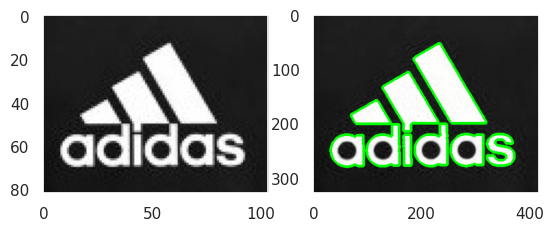

In [87]:
# contour TEST

path = f'{data}/image_for_similarity/adidas/real_adidas_4_1.jpg'

image = cv2.imread(path, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = image.copy()

# 해상도 높이기
while image.shape[1] < 300:
    image = sr2.upsample(image)

# 컨투어 찾기 전 이미지 전처리
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# 배경이 어두워야 객체 탐지가 잘 됨
gray_cvt = cv2.bitwise_not(gray.copy()) # 객체보다 배경이 밝은 경우 이미지 반전

# 객체와 배경 분리를 위한 threshold 구하기
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
_, thresh_cvt = cv2.threshold(gray_cvt, 127, 255, cv2.THRESH_BINARY)

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
thresh_cvt = cv2.erode(thresh_cvt, None, iterations=2)
thresh_cvt = cv2.dilate(thresh_cvt, None, iterations=2)

# 컨투어 찾기
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
c0 = contours[0]
c_area = cv2.contourArea(c0)

contours_cvt, hierarchy_cvt = cv2.findContours(thresh_cvt.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
c0_cvt = contours_cvt[0]
c_area_cvt = cv2.contourArea(c0_cvt)

print(c_area, c_area_cvt)
check = '원본 바탕이 검정'
if c_area > c_area_cvt: # bitwise를 하지 않은 이미지의 객체 면적이 넓은 경우 -> 제대로 객체 검출이 안 된 것
    contours = contours_cvt # final_contours 생성
    check = '원본 바탕이 흰색'
print(check)

# 컨투어 면적이 큰 순으로 정렬
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
for i in range(len(contours)):
    contour = sorted_contours[i]

    # 근사 컨투어 계산을 위한 0.01의 오차 범위 지정
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    cv2.drawContours(image, [contour], -1, (0,255,0), 3)

# 결과 출력
plt.subplot(1, 2, 1)
plt.imshow(image2, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(image)

plt.show()

### Check background color by contour Function

In [110]:
# get object color
def check_background_black(gray_image): # Get gray scale image
    gray = gray_image
    gray_cvt = cv2.bitwise_not(gray.copy()) # 객체보다 배경이 밝은 경우 이미지 반전

    # 객체와 배경 분리를 위한 threshold 구하기
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, thresh_cvt = cv2.threshold(gray_cvt, 127, 255, cv2.THRESH_BINARY)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh_cvt = cv2.erode(thresh_cvt, None, iterations=2)
    thresh_cvt = cv2.dilate(thresh_cvt, None, iterations=2)

    # 컨투어 찾기
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    c0 = sorted_contours[0]
    c_area = cv2.contourArea(c0)

    contours_cvt, hierarchy_cvt = cv2.findContours(thresh_cvt.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
    sorted_contours_cvt = sorted(contours_cvt, key=cv2.contourArea, reverse=True)
    c0_cvt = sorted_contours_cvt[0]
    c_area_cvt = cv2.contourArea(c0_cvt)

    # print(c_area, c_area_cvt)
    check = True
    if c_area > c_area_cvt: # bitwise를 하지 않은 이미지의 객체 면적이 넓은 경우 -> 제대로 객체 검출이 안 된 것
        check = False
    return check

In [111]:
path = f'{data}/image_for_similarity/adidas/real_adidas_4_1.jpg'

image = cv2.imread(path, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

print(check_background_black(gray))

True


/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_18.jpg
white


<Figure size 1500x1000 with 0 Axes>

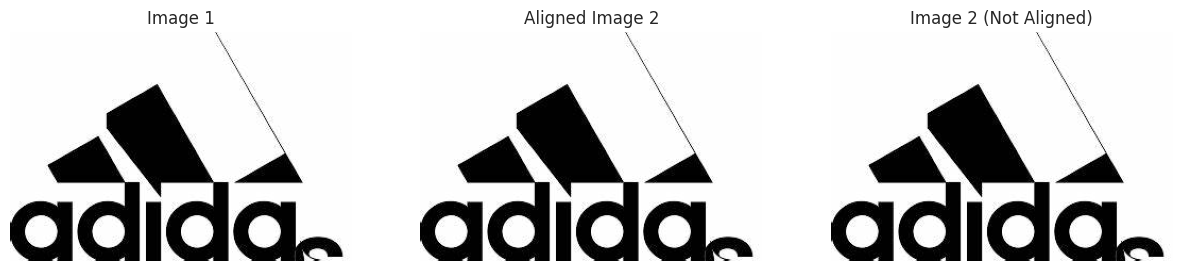

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_19.jpg
white


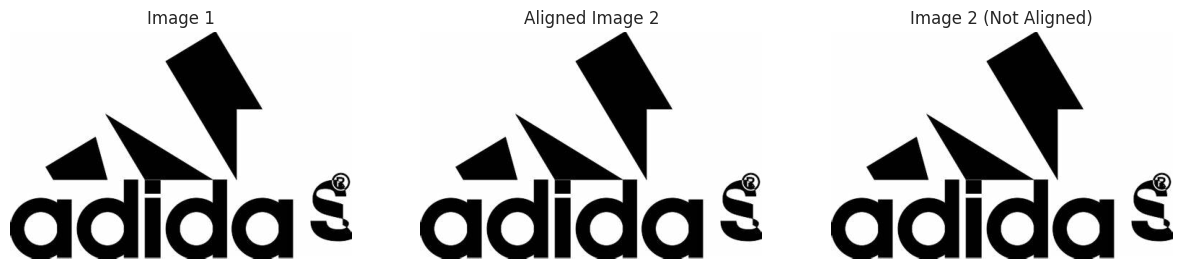

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_30.png
white


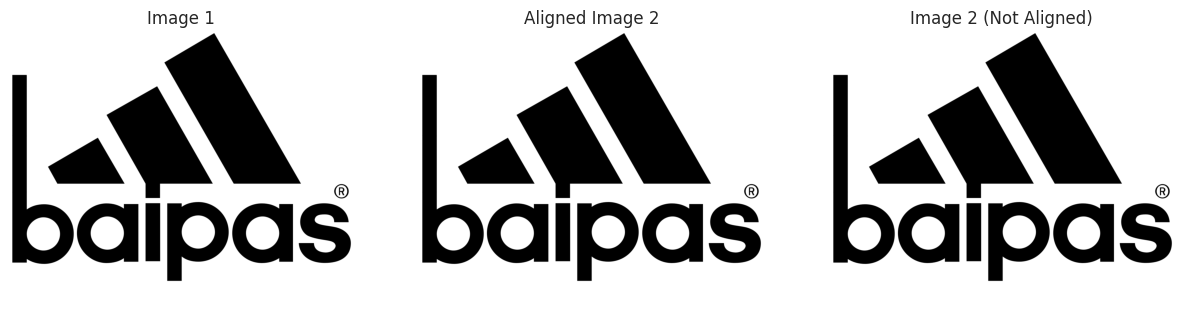

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_22.jpg
white


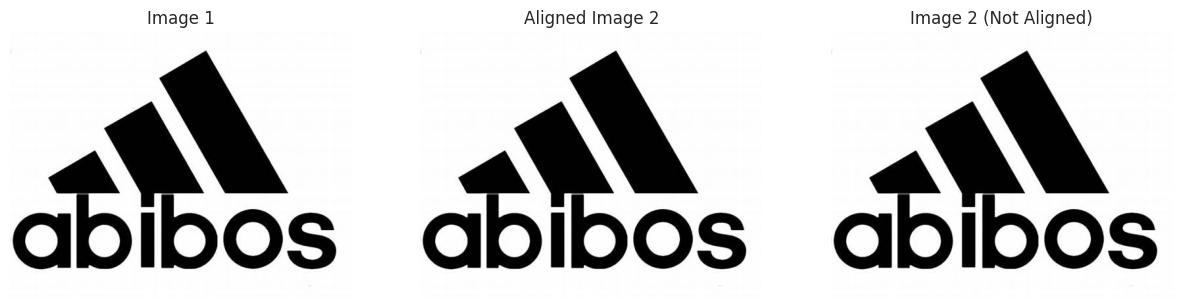

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_13.jpg
white


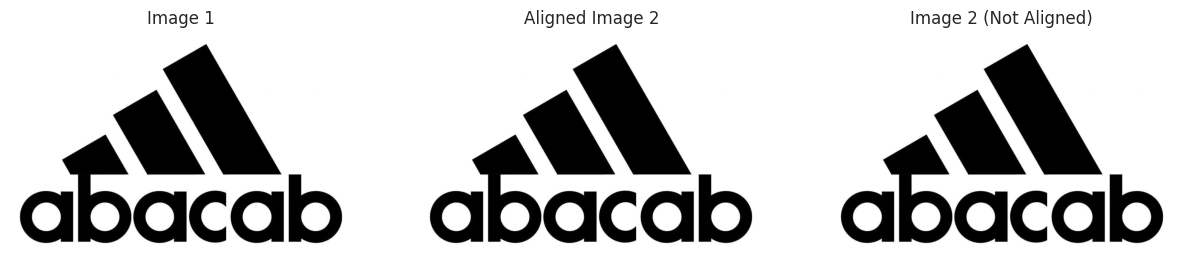

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_25.jpg
white


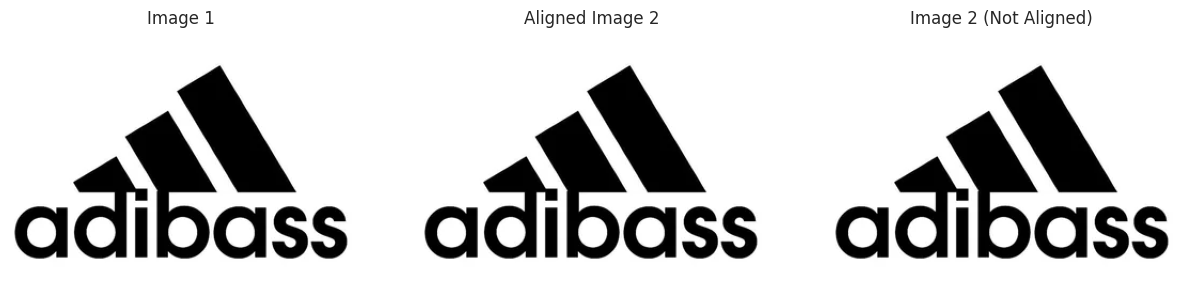

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_35.png
white


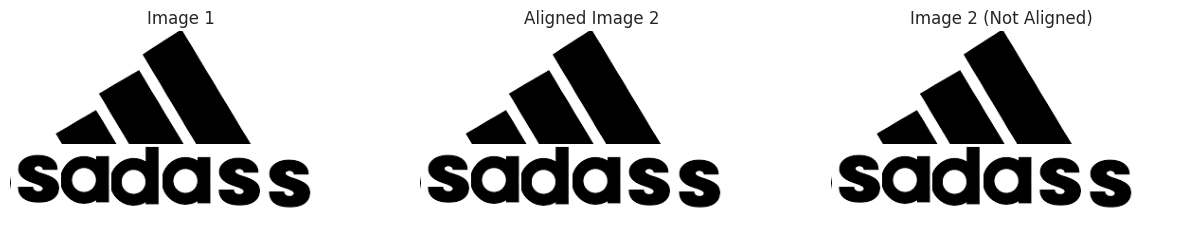

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_27.jpg
white


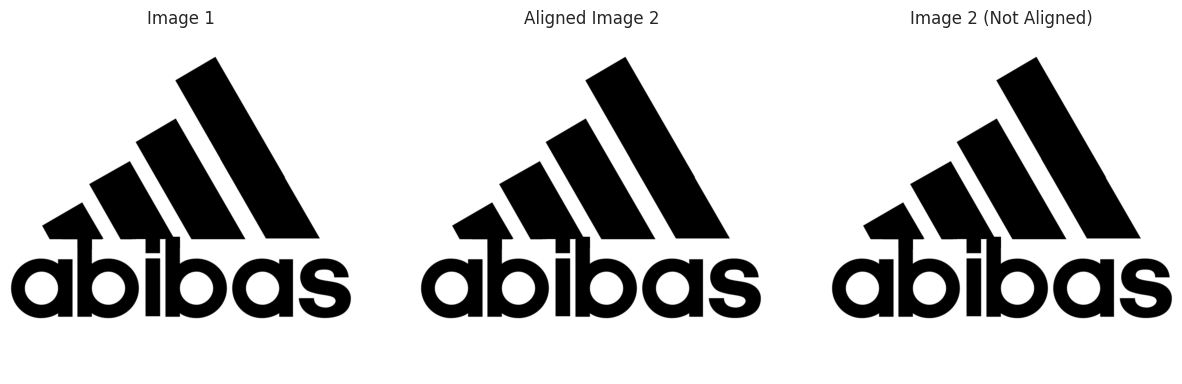

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/fake_adidas_24.jpg
white


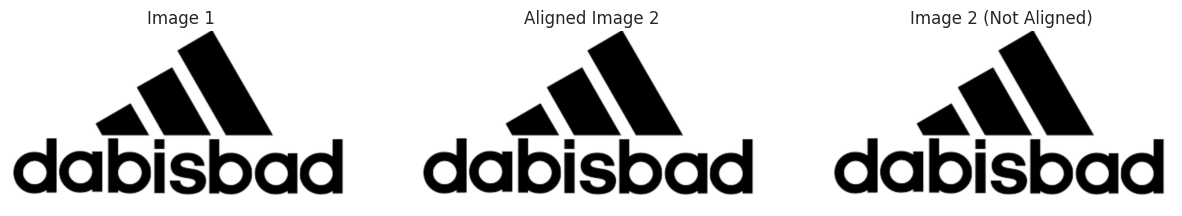

/content/drive/MyDrive/ai부트캠프/Final_Project/Data/image_for_similarity/adidas/adidas_sports_fake_1_1.jpg
white


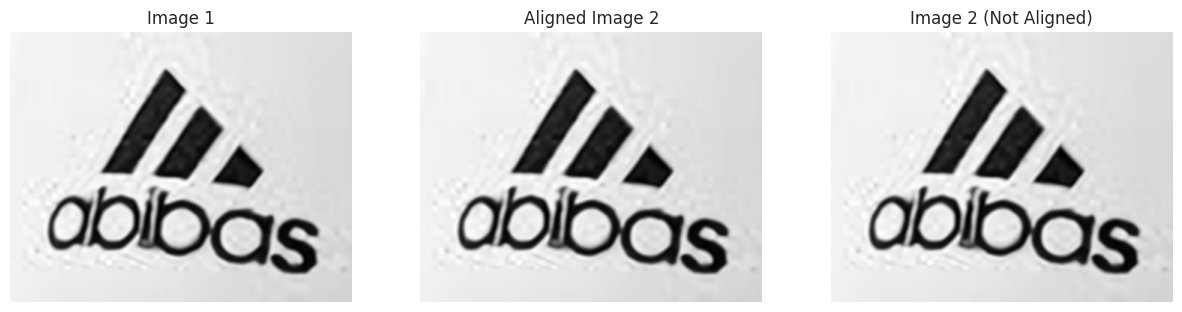

In [112]:
#### check background fucntion test

paths = []
paths.extend(list(fake.sort_values(by='total_avg', ascending=True)[:10].path))

fig = plt.figure(figsize=(15, 10))
rows = 2
cols = 4
i = 1

for path2 in paths:
    path1 = f'{data}/LOGO/adidas_sports_logo.png'
    print(path2)
    img1 = cv2.imread(path1, 1)
    img2 = cv2.imread(path2, 1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    res = None

    # upsampling cropped image
    while img2.shape[1] < 300:
        img2 = sr2.upsample(img2)

    # image to gray scale
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if check_background_black(img2):
        print('black')
    else:
        print('white')

    display_aligned_images(img2, img2, img2)

### Align image

14it [03:05, 13.28s/it]


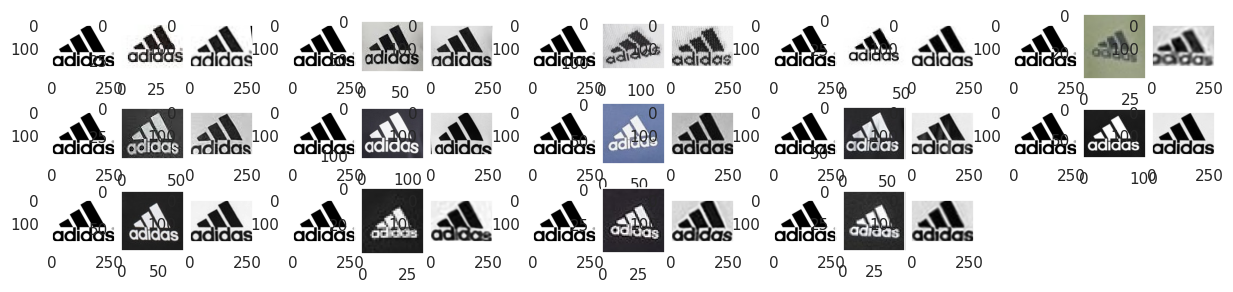

In [141]:
paths = []
# paths.extend(list(fake.sort_values(by='total_avg', ascending=True)[:].path))
paths.extend(list(real.sort_values(by='total_avg', ascending=True)[:].path))


fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(9, 5, wspace=0.2, hspace=0.2)

for i, path2 in tqdm(enumerate(paths)):
    # print(path2)
    path1 = f'{data}/LOGO/adidas_sports_logo.png'
    img1 = cv2.imread(path1, 1)
    img2 = cv2.imread(path2, 1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img1_origin = img1.copy()
    img2_origin = img2.copy()
    res = None

    # upsampling cropped image
    while img2.shape[1] < 300:
        img2 = sr2.upsample(img2)

    # image to gray scale
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if check_background_black(img2):
        pass
    else:
        img2 = cv2.bitwise_not(img2)

    img2 = cv2.bitwise_not(img2)

    # Initiate AKAZE detector
    algorithm = cv2.AKAZE_create(descriptor_type = cv2.AKAZE_DESCRIPTOR_MLDB_UPRIGHT,
                                descriptor_size = 0,
                                descriptor_channels = 3,
                                threshold = 0.00002, # default 0.001 -> 적절히 감소시킬수록 변환이 잘 됨.(0.00002)
                                nOctaves = 4, # default 4 ->
                                nOctaveLayers = 10, # default 4 -> 늘려주니 성능 상승
                                diffusivity = cv2.KAZE_DIFF_PM_G1) # default PM_G2 -> PM_G1 괜찮음
    # algorithm = cv2.ORB_create()

    # compute the descriptors with ORB
    kp1, des1 = algorithm.detectAndCompute(img1,None)
    kp2, des2 = algorithm.detectAndCompute(img2,None)

    # Define Matcher
    # ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Aligning image
    aligned = align_images(img1, img2, matches, kp1, kp2)

    # Image plot
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    ax1 = plt.Subplot(fig, inner[0])
    ax1.imshow(img1_origin)
    ax2 = plt.Subplot(fig, inner[1])
    ax2.imshow(img2_origin)
    ax3 = plt.Subplot(fig, inner[2])
    ax3.imshow(aligned, cmap='gray')
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    fig.add_subplot(ax3)

fig.show()

### Align Images Function

In [179]:
def algin_images(image1, image2): # need RGB Image
    img1 = image1
    img2 = image2

    # upsampling cropped image
    while img2.shape[1] < 300:
        img2 = sr2.upsample(img2)

    # image to gray scale
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if check_background_black(img2):
        pass
    else:
        img2 = cv2.bitwise_not(img2)

    img2 = cv2.bitwise_not(img2)

    # Initiate AKAZE detector
    algorithm = cv2.AKAZE_create(descriptor_type = cv2.AKAZE_DESCRIPTOR_MLDB_UPRIGHT,
                                descriptor_size = 0,
                                descriptor_channels = 3,
                                threshold = 0.00002, # default 0.001 -> 적절히 감소시킬수록 변환이 잘 됨.(0.00002)
                                nOctaves = 4, # default 4 ->
                                nOctaveLayers = 10, # default 4 -> 늘려주니 성능 상승
                                diffusivity = cv2.KAZE_DIFF_PM_G1) # default PM_G2 -> PM_G1 괜찮음

    # compute the descriptors with ORB
    kp1, des1 = algorithm.detectAndCompute(img1,None)
    kp2, des2 = algorithm.detectAndCompute(img2,None)

    # Define Matcher
    # ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Aligning image
    kp1 = np.float32([kp1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
    kp2 = np.float32([kp2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

    M, _ = cv2.findHomography(kp2, kp1, cv2.RANSAC)

    aligned = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))
    return img1, img2, aligned

### Subtract Image

In [180]:
cols = ['name', 'image_type', 'diff']
dicts = {col:[] for col in cols}

for file_name in tqdm(os.listdir(f'{data}/image_for_similarity/adidas')):
    # 이미지 경로 설정
    path1 = f'{data}/LOGO/adidas_sports_logo.png'
    path2 = f'{data}/image_for_similarity/adidas/{file_name}'

    # 이미지 받아오기 및 RGB 변환
    img1 = cv2.imread(path1, 1)
    img2 = cv2.imread(path2, 1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # 이미지 조정
    img1, img2, aligned = algin_images(img1, img2)

    # 'fake' 또는 'real' 추출
    parts = file_name.split('_')
    if 'fake' in parts:
        label = 'fake'
    elif 'real' in parts:
        label = 'real'
    else:
        label = None

    # 이미지 차이값 추출
    diff = np.sum(cv2.subtract(img1, aligned))

    lists = [file_name, label, diff]
    for i, col in enumerate(cols):
        dicts[col].append(lists[i])
matches_df = pd.DataFrame(dicts, columns=cols)

100%|██████████| 45/45 [04:15<00:00,  5.68s/it]


In [183]:
matches_df.columns

Index(['name', 'image_type', 'diff'], dtype='object')

In [235]:
fake = matches_df[matches_df.image_type == 'fake']
real = matches_df[matches_df.image_type == 'real']

fake_min = fake['diff'].min()
real_max = real['diff'].max()
real_mean = real['diff'].mean()
real_median = real['diff'].median()

fake_less_real_max = fake[fake['diff'] > real_max]['diff'].count()/fake['diff'].count()*100
fake_less_real_mean = fake[fake['diff'] > real_mean]['diff'].count()/fake['diff'].count()*100
fake_less_real_median = fake[fake['diff'] > real_median]['diff'].count()/fake['diff'].count()*100

 print(f'fake_less_real_max: {fake_less_real_max:.2f}%')
print(f'fake_less_real_mean: {fake_less_real_mean:.2f}%')
print(f'fake_less_real_median: {fake_less_real_median:.2f}%')

# fake[diff'']
# names = fake.sort_values(by='diff', ascending=True).head(8).name.to_list()
# names.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
# names
# display(real.sort_values(by='diff', ascending=False).head(10))

fake_less_real_max: 22.58%
fake_less_real_mean: 58.06%
fake_less_real_median: 58.06%


In [166]:
path = f'{data}/LOGO/adidas_sports_logo.png'
img1 = cv2.imread(path, 1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(path, 1)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sub_imgs = cv2.subtract(img1, img2)
np.sum(sub_imgs)

0

# Similarity Measure

### Compare Similarity